# Softmax Regression


In the last two chapters, we worked through implementations
linear regression, building everything from scratch and again using pytorch to automate the most repetitive work.

Regression is the hammer we reach for
when we want to answer *how much?* or *how many?* questions.
If you want to predict the number of dollars (the *price*)
at which a house will be sold,
or the number of wins a baseball team might have,
or the number of days that a patient
will remain hospitalized before being discharged,
then you're probably looking for a regression model.

In practice, we're more often interested in classification:
asking not *how much* but *which one*.

* Does this email belong in the spam folder or the inbox?
* Is this customer more likely *to sign up* or *not to sign up* for a subscription service?
* Does this image depict a donkey, a dog, a cat, or a rooster?
* Which movie is user most likely to watch next?

Colloquially, we use the word *classification* to describe two subtly different problems: (i) those where we are interested only in *hard* assignments of examples to categories, and (ii) those where we wish to make *soft assignments*, i.e., to assess the *probability* that each category applies. One reason why the distinction between these tasks gets blurred is because most often, even when we only care about hard assignments, we still use models that make soft assignments.


## Classification Problems

To get our feet wet, let's start off with a somewhat contrived image classification problem. Here, each input will be a grayscale 2-by-2 image. We can represent each pixel location as a single scalar, representing each image with four features $x_1, x_2, x_3, x_4$. Further, let's assume that each image belongs to one among the categories "cat", "chicken" and "dog".

First, we have to choose how to represent the labels. We have two obvious choices. Perhaps the most natural impulse would be to choose $y \in \{1, 2, 3\}$, where the integers represent {dog, cat, chicken} respectively. This is a great way of *storing* such information on a computer.
If the categories had some natural ordering among them, say if we were trying to predict {baby, child, adolescent, adult}, then it might even make sense to cast this problem as a regression and keep the labels in this format.

But general classification problems do not come with natural orderings among the classes. To deal with problems like this, statisticians invented an alternative way to represent categorical data: the one hot encoding. Here we have a vector with one component for every possible category. For a given instance, we set the component corresponding to *its category* to 1, and set all other components to 0.

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}$$

In our case, $y$ would be a three-dimensional vector, with $(1,0,0)$ corresponding to "cat", $(0,1,0)$ to "chicken" and $(0,0,1)$ to "dog".

### Network Architecture

In order to estimate multiple classes, we need a model with multiple outputs, one per category. This is one of the main differences between classification and regression models. To address classification with linear models, we will need as many linear functions as we have outputs. Each output will correspond to its own linear function. In our case, since we have 4 features and 3 possible output categories, we will need 12 scalars to represent the weights,  ($w$ with subscripts) and 3 scalars to represent the biases ($b$ with subscripts). We compute these three outputs, $o_1, o_2$, and $o_3$, for each input:

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + x_4 w_{41} + b_1,\\
o_2 &= x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + x_4 w_{42} + b_2,\\
o_3 &= x_1 w_{13} + x_2 w_{23} + x_3 w_{33} + x_4 w_{43} + b_3.
\end{aligned}
$$

We can depict this calculation with the neural network diagram below. Just as in linear regression, softmax regression is also a single-layer neural network. And since the calculation of each output, $o_1, o_2$, and $o_3$, depends on all inputs, $x_1$, $x_2$, $x_3$, and $x_4$, the output layer of softmax regression can also be described as fully connected layer.

![alt text](https://drive.google.com/uc?id=120yYCvUv0WQYjrVqtdJjIU0xy2CoEu0g)


Softmax regression is a single-layer neural network.  


### Softmax Operation

To express the model more compactly, we can use linear algebra notation. In vector form, we arrive at $\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$, a form better suited both for mathematics, and for writing code. Note that we have gathered all of our weights into a $3\times4$ matrix and that for a given example $\mathbf{x}$ our outputs are given by a matrix vector product of our weights by our inputs plus our biases $\mathbf{b}$.


If we are interested in hard classifications, we need to convert these outputs into a discrete prediction. One straightforward way to do this is to treat the output values $o_i$ as the relative confidence levels that the item belongs to each category $i$. Then we can choose the class with the largest output value as our prediction $\operatorname*{argmax}_i o_i$. For example, if $o_1$, $o_2$, and $o_3$ are 0.1, 10, and 0.1, respectively, then we predict category 2, which represents "chicken".

However, there are a few problems with using the output from the output layer directly. First, because the range of output values from the output layer is uncertain, it is difficult to judge the meaning of these values. For instance, the output value 10 from the previous example appears to indicate that we are *very confident* that the image category is *chicken*. But just how confident? Is it 100 times more likely to be a chicken than a dog or are we less confident?

Moreover how do we train this model. If the argmax matches the label, then we have no error at all! And if if the argmax is not equal to the label, then no infinitesimal change in our weights will decrease our error. That takes gradient-based learning off the table.

We might like for our outputs to correspond to probabilities, but then we would need a way to guarantee that on new (unseen) data the probabilities would be nonnegative and sum up to 1. Moreover, we would need a training objective that encouraged the model to actually estimate *probabilities*.
Fortunately, statisticians have conveniently invented a model
called softmax logistic regression that does precisely this.

In order to ensure that our outputs are nonnegative and sum to 1,
while requiring that our model remains differentiable,
we subject the outputs of the linear portion of our model
to a nonlinear *softmax* function:

$$
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \text{ where }
\hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}
$$

It is easy to see $\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$ with $0 \leq \hat{y}_i \leq 1$ for all $i$. Thus, $\hat{y}$ is a proper probability distribution and the values of $o$ now assume an easily quantifiable meaning. Note that we can still find the most likely class by

$$
\hat{\imath}(\mathbf{o}) = \operatorname*{argmax}_i o_i = \operatorname*{argmax}_i \hat y_i
$$

In short, the softmax operation preserves the orderings of its inputs, and thus does not alter the predicted category vs our simpler *argmax* model. However, it gives the outputs $\mathbf{o}$ proper meaning: they are the pre-softmax values determining the probabilities assigned to each category. Summarizing it all in vector notation we get ${\mathbf{o}}^{(i)} = \mathbf{W} {\mathbf{x}}^{(i)} + {\mathbf{b}}$ where ${\hat{\mathbf{y}}}^{(i)} = \mathrm{softmax}({\mathbf{o}}^{(i)})$.


### Vectorization for Minibatches

Again, to improve computational efficiency and take advantage of GPUs, we will typically carry out vector calculations for mini-batches of data. Assume that we are given a mini-batch $\mathbf{X}$ of examples with dimensionality $d$ and batch size $n$. Moreover, assume that we have $q$ categories (outputs). Then the minibatch features $\mathbf{X}$ are in $\mathbb{R}^{n \times d}$, weights $\mathbf{W} \in \mathbb{R}^{d \times q}$ and the bias satisfies $\mathbf{b} \in \mathbb{R}^q$.

$$
\begin{aligned}
\mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b} \\
\hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O})
\end{aligned}
$$

This accelerates the dominant operation into a matrix-matrix product $\mathbf{W} \mathbf{X}$ vs the matrix-vector products we would be executing if we processed one example at a time. The softmax itself can be computed by exponentiating all entries in $\mathbf{O}$ and then normalizing them by the sum appropriately.

## Loss Function

Now that we have some mechanism for outputting probabilities, we need to transform this into a measure of how accurate things are, i.e. we need a *loss function*. For this, we use the same concept that we already encountered in linear regression, namely likelihood maximization.

### Log-Likelihood

The softmax function maps $\mathbf{o}$ into a vector of probabilities corresponding to various outcomes, such as $p(y=\mathrm{cat}|\mathbf{x})$. This allows us to compare the estimates with reality, simply by checking how well it predicted what we observe.

$$
p(Y|X) = \prod_{i=1}^n p(y^{(i)}|x^{(i)})
\text{ and thus }
-\log p(Y|X) = \sum_{i=1}^n -\log p(y^{(i)}|x^{(i)})
$$


Maximizing $p(Y|X)$ (and thus equivalently minimizing $-\log p(Y|X)$)
corresponds to predicting the label well.
This yields the loss function (we dropped the superscript $(i)$ to avoid notation clutter):

$$
l = -\log p(y|x) = - \sum_j y_j \log \hat{y}_j
$$

Here we used that by construction $\hat{y} = \mathrm{softmax}(\mathbf{o})$ and moreover, that the vector $\mathbf{y}$ consists of all zeroes but for the correct label, such as $(1, 0, 0)$. Hence the sum over all coordinates $j$ vanishes for all but one term. Since all $\hat{y}_j$ are probabilities, their logarithm is never larger than $0$. Consequently, the loss function is minimized if we correctly predict $y$ with *certainty*, i.e. if $p(y|x) = 1$ for the correct label.

### Softmax and Derivatives

Since the Softmax and the corresponding loss are so common, it is worth while understanding a bit better how it is computed. Plugging $o$ into the definition of the loss $l$ and using the definition of the softmax we obtain:

$$
l = -\sum_j y_j \log \hat{y}_j = \sum_j y_j \log \sum_k \exp(o_k) - \sum_j y_j o_j
= \log \sum_k \exp(o_k) - \sum_j y_j o_j
$$

To understand a bit better what is going on, consider the derivative with respect to $o$. We get

$$
\partial_{o_j} l = \frac{\exp(o_j)}{\sum_k \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j = \Pr(y = j|x) - y_j
$$

In other words, the gradient is the difference between the probability assigned to the true class by our model, as expressed by the probability $p(y|x)$, and what actually happened, as expressed by $y$. In this sense, it is very similar to what we saw in regression, where the gradient was the difference between the observation $y$ and estimate $\hat{y}$. This is not coincidence. In any [exponential family](https://en.wikipedia.org/wiki/Exponential_family) model, the gradients of the log-likelihood are given by precisely this term. This fact makes computing gradients easy in practice.

### Cross-Entropy Loss

Now consider the case where we don't just observe a single outcome but maybe, an entire distribution over outcomes. We can use the same representation as before for $y$. The only difference is that rather than a vector containing only binary entries, say $(0, 0, 1)$, we now have a generic probability vector, say $(0.1, 0.2, 0.7)$. The math that we used previously to define the loss $l$ still works out fine, just that the interpretation is slightly more general. It is the expected value of the loss for a distribution over labels.

$$
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_j y_j \log \hat{y}_j
$$

This loss is called the cross-entropy loss and it is one of the most commonly used losses for multiclass classification. To demystify its name we need some information theory. The following section can be skipped if needed.

## Information Theory Basics

Information theory deals with the problem of encoding, decoding, transmitting and manipulating information (aka data), preferentially in as concise form as possible.

### Entropy

A key concept is how many bits of information (or randomness) are contained in data. It can be measured as the [entropy](https://en.wikipedia.org/wiki/Entropy) of a distribution $p$ via

$$
H[p] = \sum_j - p(j) \log p(j)
$$

One of the fundamental theorems of information theory states that in order to encode data drawn randomly from the distribution $p$ we need at least $H[p]$ 'nats' to encode it. If you wonder what a 'nat' is, it is the equivalent of bit but when using a code with base $e$ rather than one with base 2. One nat is $\frac{1}{\log(2)} \approx 1.44$ bit. $H[p] / \log 2$ is often also called the binary entropy.

To make this all a bit more theoretical consider the following: $p(1) = \frac{1}{2}$ whereas $p(2) = p(3) = \frac{1}{4}$. In this case we can easily design an optimal code for data drawn from this distribution, by using `0` to encode 1, `10` for 2 and `11` for 3. The expected number of bit is $1.5 = 0.5 * 1 + 0.25 * 2 + 0.25 * 2$. It is easy to check that this is the same as the binary entropy $H[p] / \log 2$.

### Kullback Leibler Divergence

One way of measuring the difference between two distributions arises directly from the entropy. Since $H[p]$ is the minimum number of bits that we need to encode data drawn from $p$, we could ask how well it is encoded if we pick the 'wrong' distribution $q$. The amount of extra bits that we need to encode $q$ gives us some idea of how different these two distributions are. Let us compute this directly - recall that to encode $j$ using an optimal code for $q$ would cost $-\log q(j)$ nats, and we need to use this in $p(j)$ of all cases. Hence we have

$$
D(p\|q) = -\sum_j p(j) \log q(j) - H[p] = \sum_j p(j) \log \frac{p(j)}{q(j)}
$$

Note that minimizing $D(p\|q)$ with respect to $q$ is equivalent to minimizing the cross-entropy loss. This can be seen directly by dropping $H[p]$ which doesn't depend on $q$. We thus showed that softmax regression tries the minimize the surprise (and thus the number of bits) we experience when seeing the true label $y$ rather than our prediction $\hat{y}$.

## Model Prediction and Evaluation

After training the softmax regression model, given any example features, we can predict the probability of each output category. Normally, we use the category with the highest predicted probability as the output category. The prediction is correct if it is consistent with the actual category (label). In the next part of the experiment, we will use accuracy to evaluate the model’s performance. This is equal to the ratio between the number of correct predictions and the total number of predictions.

## Summary

* We introduced the softmax operation which takes a vector maps it into probabilities.
* Softmax regression applies to classification problems. It uses the probability distribution of the output category in the softmax operation.
* Cross entropy is a good measure of the difference between two probability distributions. It measures the number of bits needed to encode the data given our model.



# Image Classification Data (Fashion-MNIST)

Before we implement softmax regression ourselves, let's pick a real dataset to work with. To make things visually compelling, we will pick an image classification dataset. The most commonly used image classification data set is the [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit recognition data set, proposed by LeCun, Cortes and Burges in the 1990s. However, even simple models achieve classification accuracy over 95% on MNIST, so it is hard to spot the differences between better models and weaker ones. In order to get a better intuition, we will use the qualitatively similar, but comparatively complex [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, proposed by [Xiao, Rasul and Vollgraf](https://arxiv.org/abs/1708.07747) in 2017.

## Getting the Data

First, import the packages or modules required in this section.



In [0]:
%matplotlib inline
import sys
sys.path.insert(0, '..')

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import time

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

Conveniently, PyTorch's `torchvision.datasets` package provides easy access to a number of benchmark vision datasets for testing our models.
The first time we invoke `data.vision.FashionMNIST(train=True)`
to collect the training data,
PyTorch will automatically retrieve the dataset via our Internet connection.
Subsequently, PyTorch will use the already-downloaded local copy.
We specify whether we are requesting the training set or the test set
by setting the value of the parameter `train` to `True` or `False`, respectively.
Recall that we will only be using the training data for training,
holding out the test set for a final evaluation of our model.

In [0]:
# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = transforms.ToTensor() 

The `ToTensor` Transform also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations introduced later.

In [0]:
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

The number of images for each category in the training set and the testing set is 6,000 and 1,000, respectively. Since there are 10 categories, the numbers of examples in the training set and the test set are 60,000 and 10,000, respectively.

In [165]:
len(mnist_train), len(mnist_test)

(60000, 10000)

We can access any example by indexing into the dataset using square brackets `[]`. In the following code, we access the image and label corresponding to the first example.

In [0]:
feature, label = mnist_train[0] # accessing the first example in the training set

In [167]:
 label = mnist_train[0][1]
 label

9

In [168]:
print(feature)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [169]:
print(label)

9


Our example, stored here in the variable `feature` corresponds to an image with a height and width of 28 pixels. PyTorch automatically scales it into a tensor with each pixel value between 0 and 1. It is stored in a 3D Tensor. Its first dimension is the number of channels. Since the data set is a grayscale image, the number of channels is 1. When we encounter color, images, we'll have 3 channels for red, green, and blue. To keep things simple, we will record the shape of the image with the height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.

In [170]:
feature.shape, feature.dtype

(torch.Size([1, 28, 28]), torch.float32)

The label of each image is represented as a scalar in PyTorch. Its type is a 64-bit integer.

In [171]:
label, type(label)

(9, int)

There are 10 categories in Fashion-MNIST: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. The following function can convert a numeric label into a corresponding text label.

In [0]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

The following defines a function that can draw multiple images and corresponding labels in a single line.

In [0]:
def show_fashion_mnist(images, labels):    
    # Here _ means that we ignore (not use) variables
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

Next, let's take a look at the image contents and text labels for the first nine examples in the training data set.

Note: PyTorch DataLoader objects don't support regular array slicing. You can instead iterate through.

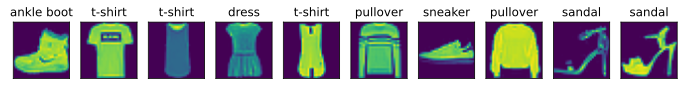

In [174]:
X=[]
y=[]
for idx, data in enumerate(mnist_train):
    if(idx>=0 and idx<10):
        X.append(data[0])
        y.append(data[1])
    if (idx>=10):
        break
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## Reading a Minibatch

To make our life easier when reading from the training and test sets we use a `DataLoader` rather than creating one from scratch, as we did in `chapter_linear_scratch`. Recall that a data loader reads a mini-batch of data with an example number of `batch_size` each time.

In practice, reading data can often be a significant performance bottleneck for training, especially when the model is simple or when the computer is fast. A handy feature of PyTorch's `DataLoader` is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via `num_workers`).

We've already applied required transformations before.

In [0]:
batch_size = 256
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

Let's look at the time it takes to read all the training data.

In [176]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'4.68 sec'

## Summary

* Fashion-MNIST is an apparel classification data set containing 10 categories, which we will use to test the performance of different algorithms in later chapters.
* We store the shape of image using height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.
* Data iterators are a key component for efficient performance. Use existing ones if available.

**Exercise:** the `torchvision` library has multiple transforms that can be applied on Tensors and Images. Implement a function that takes one MNIST image, similar to a one from the list of images above, and *returns* a random square crop from this image. Note that `crop_size` is just an integer. (Hint1: you should use a `torchvision.transform` internally)




In [0]:
def random_square_crop(img, crop_size):
  to_pil_image = transforms.ToPILImage()
  pil_img = to_pil_image(img)
  result = None
  ## write your code here
  #transforms.RandomSizedCrop(size)
  #result = transforms.functional.center_crop(pil_img,crop_size)
  top = torch.LongTensor(1).random_(0, 10).item() 
  left = torch.LongTensor(1).random_(0, 10).item() 
  #result = transforms.functional.crop(pil_img, top, left, crop_size, crop_size)
  cropObj = transforms.RandomCrop(crop_size)
  result = cropObj(pil_img)
  ## end of function
  to_tensor = transforms.ToTensor()
  return to_tensor(result)

In [178]:
torch.LongTensor(1).random_(0, 10).item() 

6

In [0]:
def show_fashion_mnist_modified(images, labels,size):    
    # Here _ means that we ignore (not use) variables
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((size, size)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

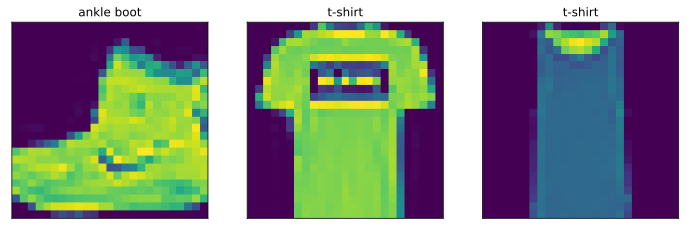

In [180]:
# test random_square_crop()
# print display first 3 croped images 
X=[]
y=[]
size = 25
for idx, data in enumerate(mnist_train):
    if(idx>=0 and idx<3):
        X.append(random_square_crop(data[0],size))
        y.append(data[1])
    if (idx>=3):
        break
show_fashion_mnist_modified(X, get_fashion_mnist_labels(y),size)


# Implementation of Softmax Regression from Scratch

:label:`chapter_softmax_scratch`


Just as we implemented linear regression from scratch,
we believe that multiclass logistic (softmax) regression
is similarly fundamental and you ought to know
the gory details of how to implement it from scratch.
As with linear regression, after doing things by hand
we will breeze through an implementation in pytorch for comparison.
To begin, let's import our packages.

In [0]:
import sys
sys.path.insert(0, '..')
from torchvision import transforms
%matplotlib inline
import torch
from torch.distributions import normal

We will work with the Fashion-MNIST dataset just introduced,

*   List item
*   List item


cuing up an iterator with batch size 256.

In [0]:
batch_size = 256
trans = transforms.ToTensor() 
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

## Initialize Model Parameters

Just as in linear regression, we represent each example as a vector.
Since each example is a $28 \times 28$ image,
we can flatten each example, treating them as $784$ dimensional vectors.
In the future, we'll talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are categories.
Because our dataset has $10$ categories,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ vector.
As with linear regression, we will initialize our weights $W$
with Gaussian noise and our biases to take the initial value $0$.

In [0]:
num_inputs = 784
num_outputs = 10

W = normal.Normal(loc = 0, scale = 0.01).sample((num_inputs, num_outputs))
b = torch.zeros(num_outputs)

In [184]:
W[783]

tensor([ 0.0065, -0.0071, -0.0115,  0.0056, -0.0173, -0.0093, -0.0052, -0.0021,
        -0.0193, -0.0023])

Recall that we need to *attach gradients* to the model parameters.
More literally, we are allocating memory for future gradients to be stored
and notifiying PyTorch that we want gradients to be calculated with respect to these parameters in the first place.

In [185]:
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## The Softmax

Before implementing the softmax regression model,
let's briefly review how `torch.sum` work
along specific dimensions in a PyTorch tensor.
Given a matrix `X` we can sum over all elements (default) or only
over elements in the same column (`dim=0`) or the same row (`dim=1`).
Note that if `X` is an array with shape `(2, 3)`
and we sum over the columns (`torch.sum(X, dim=0`),
the result will be a (1D) vector with shape `(3,)`.
If we want to keep the number of axes in the original array
(resulting in a 2D array with shape `(1,3)`),
rather than collapsing out the dimension that we summed over
we can specify `keepdim=True` when invoking `torch.sum`.

In [186]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
torch.sum(X, dim=0, keepdim=True), torch.sum(X, dim=1, keepdim=True)

(tensor([[5, 7, 9]]), tensor([[ 6],
         [15]]))

We are now ready to implement the softmax function.
Recall that softmax consists of two steps:
First, we exponentiate each term (using `torch.exp`).
Then, we sum over each row (we have one row per example in the batch)
to get the normalization constants for each example.
Finally, we divide each row by its normalization constant,
ensuring that the result sums to $1$.
Before looking at the code, let's recall
what this looks expressed as an equation:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$$

The denominator, or normalization constant,
is also sometimes called the partition function
(and its logarithm the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles).

In [0]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition  # The broadcast mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability.
Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because failed to take precautions against numerical overflow or underflow
due to large (or very small) elements of the matrix,
as we did in
:numref:`chapter_naive_bayes`.

In [188]:
X = normal.Normal(loc = 0, scale = 1).sample((2, 5))
X_prob = softmax(X)
X_prob, torch.sum(X_prob, dim=1)

(tensor([[0.1581, 0.3690, 0.0803, 0.3103, 0.0823],
         [0.3476, 0.1297, 0.1079, 0.3421, 0.0727]]), tensor([1.0000, 1.0000]))

## The Model

Now that we have defined the softmax operation,
we can implement the softmax regression model.
The below code defines the forward pass through the network.
Note that we flatten each original image in the batch
into a vector with length `num_inputs` with the `view` function
before passing the data through our model.

In [0]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

Next, we need to implement the cross entropy loss function,
introduced in :numref:`chapter_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.


Recall that cross entropy takes the negative log likelihood
of the predicted probability assigned to the true label $-\log p(y|x)$.
Rather than iterating over the predictions with a Python `for` loop
(which tends to be inefficient), we can use the `gather` function
which allows us to select the appropriate terms
from the matrix of softmax entries easily.
Below, we illustrate the `gather` function on a toy example,
with 3 categories and 2 examples.

In [190]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.tensor([0, 2])
torch.gather(y_hat, 1, y.unsqueeze(dim=1)) # y has to be unsqueezed so that shape(y_hat) = shape(y)

tensor([[0.1000],
        [0.5000]])

Now we can implement the cross-entropy loss function efficiently
with just one line of code.

In [0]:
def cross_entropy(y_hat, y):
    return -torch.gather(y_hat, 1, y.unsqueeze(dim=1)).log()

# y.unsqueeze(dim=1) -> [[0],
#                       [2]]
# https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms
# https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch 

#torch.gather creates a new tensor from the input tensor by taking the values from each row along the input dimension dim. 
#The values in torch.LongTensor, passed as index, specify which value to take from each 'row'. 
#The dimension of the output tensor is same as the dimension of index tensor. 

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with highest predicted probability
whenever we must output a *hard* prediction. Indeed, many applications require that we make a choice. Gmail must catetegorize an email into Primary, Social, Updates, or Forums. It might estimate probabilities internally, but at the end of the day it has to choose one among the categories.

When predictions are consistent with the actual category `y`, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although we cannot optimize accuracy directly (it is not differentiable), it's often the performance metric that we care most about, and we will nearly always report it when training classifiers.

To compute accuracy we do the following:
First, we execute `y_hat.argmax(dim=1)`
to gather the predicted classes
(given by the indices for the largest entires each row).
The result has the same shape as the variable `y`.
Now we just need to check how frequently the two match. The result is PyTorch tensor containing entries of 0 (false) and 1 (true). Since the attribute `mean` can only calculate the mean of floating types,
we also need to convert the result to `float`. Taking the mean yields the desired result.

In [0]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

We will continue to use the variables `y_hat` and `y`
defined in the `gather` function,
as the predicted probability distribution and label, respectively.
We can see that the first example's prediction category is 2
(the largest element of the row is 0.6 with an index of 2),
which is inconsistent with the actual label, 0.
The second example's prediction category is 2
(the largest element of the row is 0.5 with an index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.

In [193]:
accuracy(y_hat, y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the data set
(accessed via `data_iter`).

In [0]:
# The function will be gradually improved: the complete implementation will be
# discussed in the "Image Augmentation" section
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.size()[0]  # y.size()[0] = batch_size
    return acc_sum / n

Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,
i.e. 0.1 for 10 classes.

In [195]:
evaluate_accuracy(test_iter, net)

0.0851

## Model Training

The training loop for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression earlier in this chapter.
Again, we use the mini-batch stochastic gradient descent
to optimize the loss function of the model.
Note that the number of epochs (`num_epochs`),
and learning rate (`lr`) are both adjustable hyper-parameters.
By changing their values, we may be able to increase the classification accuracy of the model. In practice we'll want to split our data three ways
into training, validation, and test data, using the validation data to choose the best values of our hyperparameters.

In [196]:
num_epochs, lr = 5, 0.001

def train(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer, params=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum = 0.0, 0.0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            trainer.zero_grad() # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            l.backward()                
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()            
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / len(train_iter), test_acc))

trainer = torch.optim.SGD([W, b], lr) 
train(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, trainer, [W, b])

epoch 1, loss 223.1888, train acc 188.617, test acc 0.807
epoch 2, loss 158.3152, train acc 205.115, test acc 0.820
epoch 3, loss 143.2626, train acc 208.477, test acc 0.828
epoch 4, loss 134.9171, train acc 210.855, test acc 0.830
epoch 5, loss 133.4325, train acc 211.213, test acc 0.824


## Prediction

Now that training is complete, our model is ready to classify some images.
Given a series of images, we will compare their actual labels
(first line of text output) and the model predictions
(second line of text output).

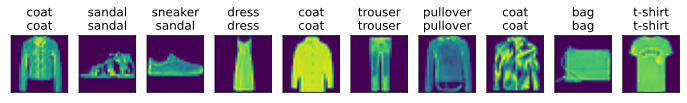

In [197]:
for X, y in test_iter:
    break

# the functions "get_fashion_mnist_labels" and "show_fashion_mnist" are defined above in this notebook
true_labels = get_fashion_mnist_labels(y.detach().numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).detach().numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

show_fashion_mnist(X[10:20], titles[10:20])

## Summary

With softmax regression, we can train models for multi-category classification. The training loop is very similar to that in linear regression: retrieve and read data, define models and loss functions,
then train models using optimization algorithms. As you'll soon find out, most common deep learning models have similar training procedures.

# Concise Implementation of Softmax Regression

Just as PyTorch made it much easier to implement linear regression, we'll find it similarly (or possibly more)
convenient for implementing classification models. Again, we begin with our import ritual.

In [0]:
import sys
sys.path.insert(0, '..')
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np


Let's stick with the Fashion-MNIST dataset and keep the batch size at $256$ as in the last section.

In [0]:
batch_size = 256

# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = torchvision.transforms.ToTensor() 
mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

In [0]:
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

## Initialize Model Parameters

As mentioned in `chapter_softmax`, the output layer of softmax regression is a fully connected (`Linear`) layer. Therefore, to implement our model, we just need to add one `Linear` layer with 10 outputs to our `Sequential`. Again, here, the `Sequential` isn't really necessary, but we might as well form the habit since it will be ubiquitous when implementing deep models. Again, we initialize the weights at random with zero mean and standard deviation 0.01.

In [201]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,784)
    
net = nn.Sequential(Reshape(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## The Softmax

In the previous example, we calculated our model's output and then ran this
output through the cross-entropy loss. Mathematically, that's a perfectly reasonable thing to do. However,
computationally, things can get hairy when dealing with exponentiation due to
numerical stability issues, a matter we've already discussed a few times
(e.g. in `chapter_naive_bayes`) and in the problem set of the previous chapter).
Recall that the softmax function calculates $\hat y_j = \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}$, where $\hat y_j$
is the j-th element of ``yhat`` and $z_j$ is the j-th element of the input
``y_linear`` variable, as computed by the softmax.

If some of the $z_i$ are very large (i.e. very positive),
$e^{z_i}$ might be larger than the largest number
we can have for certain types of ``float`` (i.e. overflow).
This would make the denominator (and/or numerator) ``inf`` and we get zero,
or ``inf``, or ``nan`` for $\hat y_j$.
In any case, we won't get a well-defined return value for ``cross_entropy``. This is the reason we subtract $\text{max}(z_i)$
from all $z_i$ first in ``softmax`` function.
You can verify that this shifting in $z_i$
will not change the return value of ``softmax``.

After the above subtraction/ normalization step,
it is possible that $z_j$ is very negative.
Thus, $e^{z_j}$ will be very close to zero
and might be rounded to zero due to finite precision (i.e underflow),
which makes $\hat y_j$ zero and we get ``-inf`` for $\text{log}(\hat y_j)$.
A few steps down the road in backpropagation,
we start to get horrific not-a-number (``nan``) results printed to screen.

Our salvation is that even though we're computing these exponential functions, we ultimately plan to take their log in the cross-entropy functions.
It turns out that by combining these two operators
``softmax`` and ``cross_entropy`` together,
we can escape the numerical stability issues
that might otherwise plague us during backpropagation.
As shown in the equation below, we avoided calculating $e^{z_j}$
but directly used $z_j$ due to $\log(\exp(\cdot))$.

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}\right) \\
& = \log{(e^{z_j})}-\text{log}{\left( \sum_{i=1}^{n} e^{z_i} \right)} \\
& = z_j -\log{\left( \sum_{i=1}^{n} e^{z_i} \right)}
\end{aligned}
$$

We'll want to keep the conventional softmax function handy
in case we ever want to evaluate the probabilities output by our model.
But instead of passing softmax probabilities into our new loss function,
we'll just pass $\hat{y}$ and compute the softmax and its log
all at once inside the softmax_cross_entropy loss function,
which does smart things like the log-sum-exp trick ([see on Wikipedia](https://en.wikipedia.org/wiki/LogSumExp)).


In [0]:
loss = nn.CrossEntropyLoss()

## Optimization Algorithm

We use the mini-batch random gradient descent
with a learning rate of $0.1$ as the optimization algorithm.
Note that this is the same choice as for linear regression
and it illustrates the general applicability of the optimizers.

## Training

Next, we use the training functions defined in the last section to train a model.

In [203]:
num_epochs = 10
lr = 0.1

trainer = torch.optim.SGD(net.parameters(), lr) 

for epoch in range(num_epochs): 
  train_loss_epoch = 0.0
  net.train()
  for X, y in train_iter:  
    y_hat = net(X)
    l = loss(y_hat, y)
    train_loss_epoch += l
    trainer.zero_grad() 
    l.backward() 
    trainer.step() 
  train_loss_epoch /= len(train_iter)
  
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    for X_test, y_test in test_iter:
      b_l = loss(net(X_test), y_test) 
      test_loss_epoch += b_l
    test_loss_epoch /= len(test_iter)  
  print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss_epoch, test_loss_epoch)) 

epoch 1, train loss 0.7851331830024719, test loss 0.6357836127281189
epoch 2, train loss 0.5712599754333496, test loss 0.5887656211853027
epoch 3, train loss 0.5256920456886292, test loss 0.5510953664779663
epoch 4, train loss 0.5016950964927673, test loss 0.5167006254196167
epoch 5, train loss 0.485610693693161, test loss 0.5023133158683777
epoch 6, train loss 0.4740023612976074, test loss 0.500957727432251
epoch 7, train loss 0.4647983908653259, test loss 0.5098615884780884
epoch 8, train loss 0.4588271379470825, test loss 0.49713334441185
epoch 9, train loss 0.4521200656890869, test loss 0.4949071407318115
epoch 10, train loss 0.44766396284103394, test loss 0.4818187355995178


Note that in many cases, PyTorch takes specific precautions
in addition to the most well-known tricks for ensuring numerical stability.
This saves us from many common pitfalls that might befall us
if we were to code all of our models from scratch.

**Exercise:** We will copy the code from above, and will place it in the cell below. Change the function below to compute the train and test accuracies.
However, this time compute top5 accuracy, and return it for test data set.

In [0]:
from __future__ import print_function, absolute_import

__all__ = ['accuracy']

def accuracy_topk(output, target, topk=(5,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk) 
    #print(maxk) #5
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    #print(pred) for a single test sample
    #tensor([[9, 2, 1,  ..., 8, 1, 5],
     #   [7, 6, 0,  ..., 6, 3, 7],
      #  [5, 4, 4,  ..., 3, 4, 8],
      #  [8, 0, 3,  ..., 0, 2, 9],
       # [2, 8, 2,  ..., 4, 0, 2]])
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    
    #print(correct)
    #tensor([[ True,  True,  True,  ...,  True,  True,  True],
    #    [False, False, False,  ..., False, False, False],
     #   [False, False, False,  ..., False, False, False],
      #  [False, False, False,  ..., False, False, False],
       # [False, False, False,  ..., False, False, False]])

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        #print(correct_k)
        #tensor(9948.)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [205]:
net.apply(init_weights) # this line is to reset the weights of the network

def good_num_epochs():
  ## compute the top5 accuracy and return it  
  lr = 0.1
  trainer = torch.optim.SGD(net.parameters(), lr) 
  num_epochs = 10
  top5_acc_test = 0.0 #top 5 test accuracy?
  correct = 0
  total = 0
  for epoch in range(num_epochs): 
    train_loss_epoch = 0.0
    net.train()
    for X, y in train_iter:  
      y_hat = net(X)
      l = loss(y_hat, y)
      train_loss_epoch += l
      trainer.zero_grad() 
      l.backward() 
      trainer.step() 
    train_loss_epoch /= len(train_iter)
    train_acc = evaluate_accuracy(train_iter,net)
  test_iter = DataLoader(mnist_test, len(mnist_test), shuffle=False, num_workers=0)
  net.eval()
  with torch.no_grad():
      test_loss_epoch = 0.0
      for X_test, y_test in test_iter:
        y_test_hat = net(X_test)
        b_l = loss(net(X_test), y_test) 
        test_loss_epoch += b_l
        total += y_test.size(0)
        correct += (y_test_hat.argmax(dim=1) == y_test).sum().item() # implement top5 score 
      test_loss_epoch /= len(test_iter)      
  #test_iter = DataLoader(mnist_test[0], 1, shuffle=False, num_workers=0)  
    #top5_acc_test = correct / total
  test_acc = evaluate_accuracy(test_iter,net)
  top5_acc_test = accuracy_topk(y_test_hat,y_test)[0].item()/100
  #top5_acc_test = round(top5_acc_test[0].item(),4)
    #print('epoch {}, train loss {}, test loss {} , train acc {}, test acc {}'.format(epoch+1, train_loss_epoch, test_loss_epoch,train_acc,test_acc)) 
  #print(test_acc)
  ## end of change area
  #return round(top5_acc_test[0].item(),4)
  return top5_acc_test
 
good_num_epochs()

0.9956999969482422

### Evaluating the model

\begin{equation}
\text{accuracy} = \frac{1}{N} \text{# correctly classified}
\end{equation}

#### Confusion matrix

|          | Predicted Positive | Predicted Negative |
|----------| ------------------ |:------------------:|
| **Positive** | True Positive ($TP$) | False Negative ($FN$)|
| **Negative** | False Positive ($FP$)| True Negative ($TN$) |


#### Trade-off between Sensitivity and Specificity

\begin{equation}
\text{sensitivity} = \frac{TP}{TP + FN}
\end{equation}

\begin{equation}
\text{specificity} = \frac{TP}{TP + FP}
\end{equation}

#### Question on Confusion Matrix (TODO)





**Exercise:** as you have noticed already, the Fashion-MNIST dataset offers multiple categories (classes), this is a multi-class classification problem. Another classification task would be binary classification between cats and dogs, for instance. Using Fashion-MNIST data, create a model that classifies between trousers and t-shirts only. This would cast the problem as a binary classification task.

*Note:* you can use the same network architecture from above (with only one layer). The only difference is in the loss function you use, in pytorch. Because now the output of the model should be using "Sigmoid", instead of a "Softmax". 

Write a function that computes the following metrics on the *test set* of Fashion-MNIST using those two classes (trousers vs. t-shirts). Compute the true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, sensitivity, specificity, f1-score, and accuracy. [Read more here](https://en.wikipedia.org/wiki/Sensitivity_and_specificity). The function should return a dictionary with all these values as entries (please fill them in as normal float numbers). 


In [0]:
def BCE_loss1(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [0]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def trousers_vs_t_shirts():  
  output_metrics = dict()
  output_metrics["true_positive_rate"] = None
  output_metrics["false_positive_rate"] = None
  output_metrics["true_negative_rate"] = None
  output_metrics["false_negative_rate"] = None
  output_metrics["precision"] = None
  output_metrics["recall"] = None
  output_metrics["sensitivity"] = None
  output_metrics["specificity"] = None
  output_metrics["f1_score"] = None
  output_metrics["accuracy"] = None  
  np.random.seed(0)
  torch.manual_seed(0)
  
  ## write your code here
  # 1. create a network with a sigmoid output layer.
        
  net = nn.Sequential(Reshape(), nn.Linear(784, 1))
  net.apply(init_weights)
  loss = nn.BCEWithLogitsLoss()
         
    
  num_epochs = 10
  lr = 0.1
  trainer = torch.optim.SGD(net.parameters(), lr) 

  for epoch in range(num_epochs): 
      train_loss_epoch = 0.0
      net.train()
      for X, y in train_iter:  
          indices_train = (y == 0) | (y == 1) 
          X_train = X[indices_train]
          y_train = y[indices_train]
                    
          y_hat = net(X_train.type(torch.FloatTensor))
          y_train = y_train.type_as(y_hat)
          l = loss(y_hat, y_train.reshape(y_hat.shape))
          train_loss_epoch += l
          trainer.zero_grad() 
          l.backward() 
          trainer.step()
      #print('epoch {}'.format(epoch+1))
          
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    if sys.platform.startswith('win'):
      # set 0 for windows
      # 0 means no additional processes are needed to speed up the reading of data
      num_workers = 0
    else:
      num_workers = 4
    
    test_iter = DataLoader(mnist_test, len(mnist_test), shuffle=False, num_workers=num_workers)
    for X_test, y_test in test_iter:
        indices_test = (y_test == 0) | (y_test == 1) 
        X_test = X_test[indices_test]
        y_test = y_test[indices_test]
        y_test_hat = net(X_test.type(torch.FloatTensor))
        y_test = y_test.type_as(y_test_hat)
        y_test_hat = y_test_hat.reshape(y_test.shape)
        b_l = loss(y_test_hat, y_test) 
        test_loss_epoch += b_l
        total = y_test.size(0)
        # The predicted results are processed through BCElosswithlogits, hence the outputs are
        # passed through the sigmoid layer to turn it into probabilities. 
        y_test_hat = torch.sigmoid(y_test_hat)
        
        #print(total)
        #print(y_test_hat)
        correct = (y_test_hat>0.5) == y_test    
        #print(y_test_hat)
        trousers_hat = correct.float().sum()    
        #print(trousers_hat)
        t_shirts_hat = total - trousers_hat
        #print(t_shirts_hat)
        trousers = (y_test > 0).float().sum()
        t_shirts =total - trousers
        #print(trousers)
        #print(t_shirts)
                
  #print(BCE_loss(y_test_hat,y_test))   
  #2. fill in the correct values in the output_metrics dictionary
 # Confusion matrix
  confusion_mat=confusion_matrix(y_test.numpy(), y_test_hat.round().numpy())
 
 # FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat) 
  FP = confusion_mat[0][1]
 
  #FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)
  FN = confusion_mat[1][0]
  
  #TP = np.diag(confusion_mat)
  TP = confusion_mat[1][1]
 
  #TN = confusion_mat.sum() - (FP + FN + TP)  
  TN = confusion_mat[0][0]

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)

  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)

  clss_report = classification_report(y_test.numpy(), y_test_hat.round().numpy(), target_names=["t_shirts","trousers"])
  #print(clss_report)
  output_metrics["true_positive_rate"] = TPR
  output_metrics["false_positive_rate"] = FPR
  output_metrics["true_negative_rate"] = TNR
  output_metrics["false_negative_rate"] = FNR
  output_metrics["precision"] = PPV
  output_metrics["recall"] = NPV
  output_metrics["sensitivity"] = TPR
  output_metrics["specificity"] = TNR
  output_metrics["f1_score"] =2 * ((PPV * NPV)/ (PPV + NPV))
  output_metrics["accuracy"] = ACC
  #print(clss_report)
  
  ## end of function
  return output_metrics



In [221]:
  trousers_vs_t_shirts()

{'accuracy': 0.9845,
 'f1_score': 0.98451205743566,
 'false_negative_rate': 0.019,
 'false_positive_rate': 0.012,
 'precision': 0.9879154078549849,
 'recall': 0.9811320754716981,
 'sensitivity': 0.981,
 'specificity': 0.988,
 'true_negative_rate': 0.988,
 'true_positive_rate': 0.981}